I decided to treat this as a classification problem by creating a new binary
variable affair (did the woman have at least one affair?) and trying to
predict the classification for each woman.

# Dataset

The dataset I chose is the affairs dataset that comes with Statsmodels. It
was derived from a survey of women in 1974 by Redbook magazine, in
which married women were asked about their participation in extramarital
affairs. More information about the study is available in a 1978 paper from
the Journal of Political Economy.

## Description of Variables

The dataset contains 6366 observations of 9 variables:

* **rate_marriage**: woman's rating of her marriage (1 = very poor, 5 = very good)
* **age**: woman's age
* **yrs_married**: number of years married
* **children**: number of children
* **religious**: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)

* **educ**: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)

* **occupation**: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)

* **occupation_husb**: husband's occupation (same coding as above)
* **affairs**: time spent in extra-marital affairs

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from patsy import dmatrices

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
 
from sklearn.model_selection import cross_val_score 

In [2]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import seaborn as sns

sns.set()
%matplotlib inline

In [3]:
data = sm.datasets.fair.load_pandas().data
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affairs          6366 non-null   float64
dtypes: float64(9)
memory usage: 447.7 KB


In [6]:
data.isna().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
dtype: int64

In [7]:
data.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


In [4]:
#add "affair" column: 1 represents having affairs, 0 represents not 
data['affairs'] = (data.affairs > 0).astype(int)

In [24]:
data

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1
...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0


In [5]:
y, X = dmatrices('affairs ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', 
                 data, return_type="dataframe")

In [6]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [37]:
X.head()

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0


In [7]:
y = np.ravel(y)

In [40]:
y

array([1., 1., 1., ..., 0., 0., 0.])

### EDA

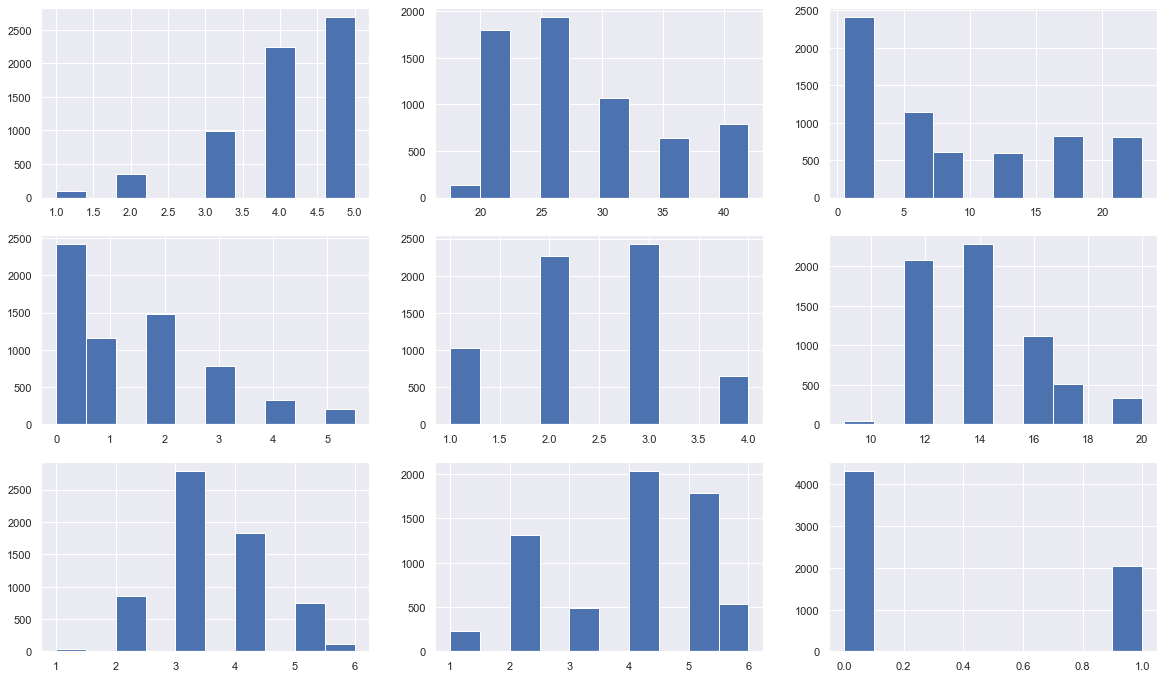

In [54]:
plt.figure(figsize = (20,16), facecolor = 'white')
count = 1

for i in data:
    if count <= 10:
        ax = plt.subplot(4,3, count)
        plt.hist(data[i])
    count+=1
    
plt.show()

In [55]:
count = 1
for i in data:
    if count <= 10:
        plt.scatter(data[i].value_counts())      
    count+=1

5.0    2684
4.0    2242
3.0     993
2.0     348
1.0      99
Name: rate_marriage, dtype: int64
27.0    1931
22.0    1800
32.0    1069
42.0     793
37.0     634
17.5     139
Name: age, dtype: int64
2.5     2034
6.0     1141
16.5     818
23.0     811
9.0      602
13.0     590
0.5      370
Name: yrs_married, dtype: int64
0.0    2414
2.0    1481
1.0    1159
3.0     781
4.0     328
5.5     203
Name: children, dtype: int64
3.0    2422
2.0    2267
1.0    1021
4.0     656
Name: religious, dtype: int64
14.0    2277
12.0    2084
16.0    1117
17.0     510
20.0     330
9.0       48
Name: educ, dtype: int64
3.0    2783
4.0    1834
2.0     859
5.0     740
6.0     109
1.0      41
Name: occupation, dtype: int64
4.0    2030
5.0    1779
2.0    1308
6.0     530
3.0     490
1.0     229
Name: occupation_husb, dtype: int64
0    4313
1    2053
Name: affairs, dtype: int64


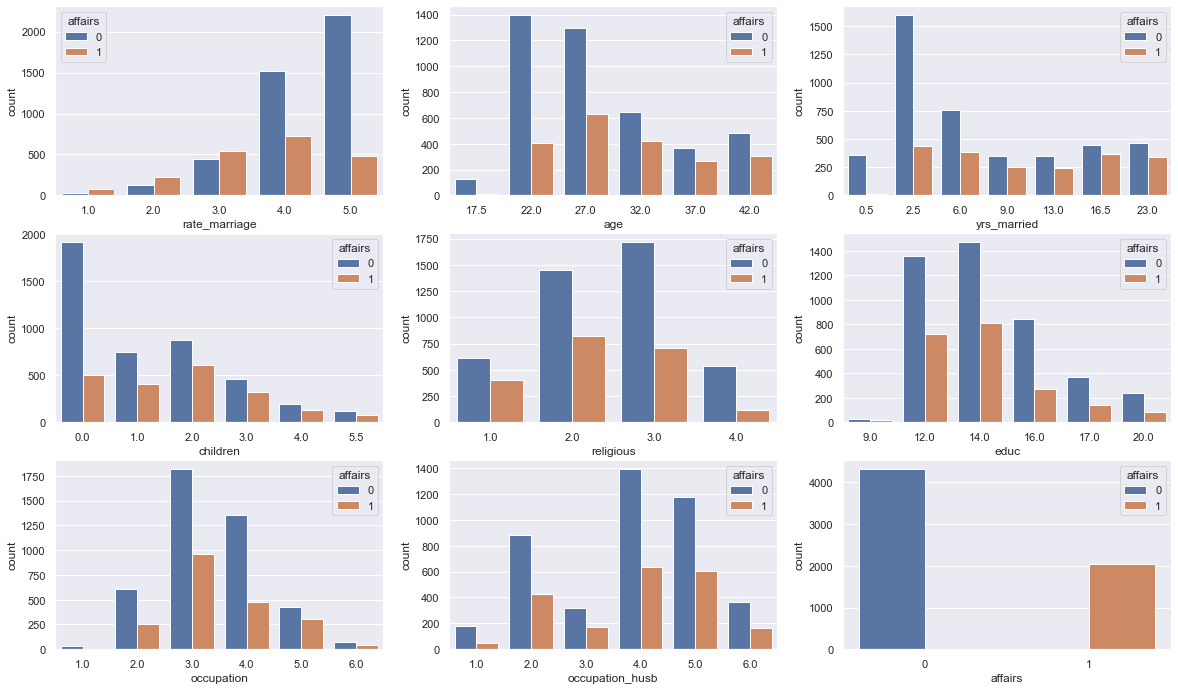

In [70]:
plt.figure(figsize = (20,16), facecolor = 'white')
count = 1

for i in data:
    if count <= 10:
        ax = plt.subplot(4,3, count)
        sns.countplot(x = i ,data=data, hue = "affairs")
    count+=1
    
plt.show()

<AxesSubplot:>

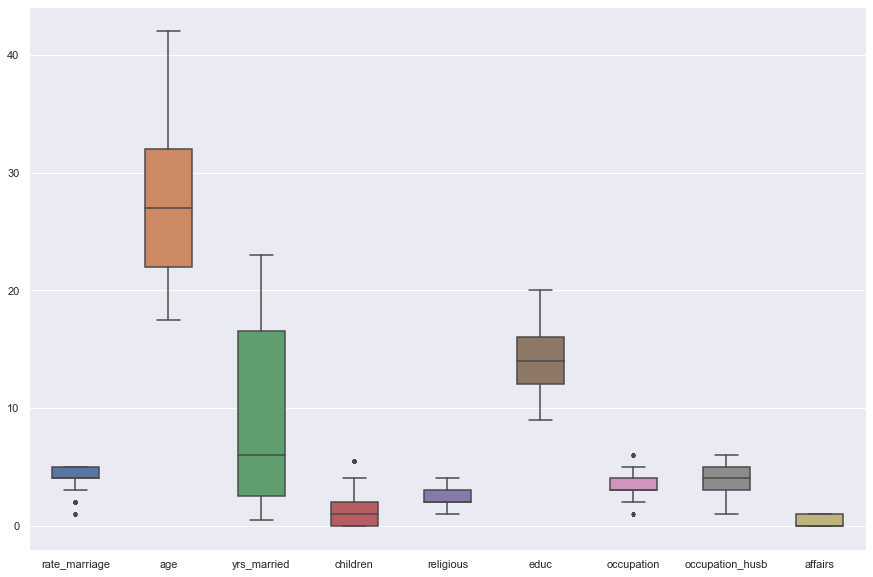

In [73]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data, width= 0.5,ax=ax,  fliersize=3)

## Modelling

In [15]:
X.drop(['occ_6', 'occ_husb_6'], axis = 1, inplace = True)
X

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [16]:
scaled = StandardScaler()
X_scaled = scaled.fit_transform(X)

In [79]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = X.columns

#let's check the values
vif

C:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,vif,Features
0,NaN,Intercept
1,6.601013,occ_2
2,12.371332,occ_3
3,9.753158,occ_4
4,5.665892,occ_5
5,2.390531,occ_husb_2
6,1.596818,occ_husb_3
7,2.668542,occ_husb_4
8,2.546194,occ_husb_5
9,1.038562,rate_marriage


In [17]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7268445839874411

In [18]:
from sklearn.metrics import precision_score, recall_score, classification_report

In [19]:
y_preds = model.predict(X_test)

acc = accuracy_score(y_test, y_preds)
pre = precision_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)

In [20]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81       849
         1.0       0.65      0.40      0.49       425

    accuracy                           0.73      1274
   macro avg       0.70      0.64      0.65      1274
weighted avg       0.71      0.73      0.71      1274



In [21]:
print(acc,pre,rec)

0.7268445839874411 0.6486486486486487 0.3952941176470588


In [22]:
confusion_matrix(y_test,y_preds)

array([[758,  91],
       [257, 168]], dtype=int64)

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test,y_preds)
print(roc_auc)

0.6440545971038591


In [25]:
F1_Score = 2*(rec * pre) / (rec + pre)
F1_Score

0.49122807017543857

In [26]:
fpr, tpr, threshold = roc_curve(y_test,y_preds)

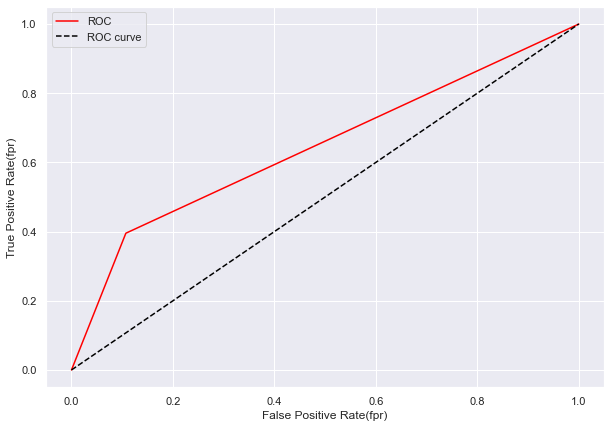

In [35]:
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, c = 'red', label = 'ROC' )
plt.plot([0,1],[0,1], c = 'black', label = 'ROC curve', linestyle = '--')
plt.xlabel('False Positive Rate(fpr)')
plt.ylabel('True Positive Rate(fpr)')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [36]:
log_reg_grid = { "C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [37]:
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(42)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions = log_reg_grid,
                                n_jobs = -1,
                                cv = 5,
                                n_iter = 20,
                                verbose = True)

rs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:   34.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [38]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 11.288378916846883}

In [39]:
model1 = LogisticRegression( C = 11.288378916846883,
                           solver = "liblinear")
model1.fit(X_train,y_train)
model1.score(X_test,y_test)

0.728414442700157

In [40]:
rs_log_reg.score(X_test,y_test)

0.728414442700157

In [42]:
print("classification_report:\n\n", classification_report( y_test, y_preds))

classification_report:

               precision    recall  f1-score   support

         0.0       0.75      0.89      0.81       849
         1.0       0.65      0.40      0.49       425

    accuracy                           0.73      1274
   macro avg       0.70      0.64      0.65      1274
weighted avg       0.71      0.73      0.71      1274



In [43]:
from sklearn.model_selection import GridSearchCV

gs_clf = GridSearchCV(LogisticRegression() ,
                      param_grid = log_reg_grid,
                      cv = 5,
                      n_jobs = -1,
                      verbose = 2,
                      refit = True
                     )

gs_clf.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=2)

In [44]:
gs_clf.best_params_

{'C': 11.288378916846883, 'solver': 'liblinear'}

In [45]:
gs_clf.score(X_test,y_test)

0.728414442700157

In [47]:
from sklearn.model_selection import cross_val_score

cv_acc = cross_val_score(gs_clf,
                         X_scaled,
                         y,
                         cv = 5,
                         scoring = "accuracy")
cv_acc

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


array([0.71271586, 0.72270228, 0.71877455, 0.71877455, 0.75176748])

In [52]:
cv_pre= cross_val_score(gs_clf,
                         X_scaled,
                         y,
                         cv = 5,
                         scoring = "precision")
cv_pre

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


array([0.5974026 , 0.64356436, 0.61373391, 0.6023622 , 0.69915254])

In [48]:
cv_rec = cross_val_score(gs_clf,
                         X_scaled,
                         y,
                         cv = 5,
                         scoring = "recall")
cv_rec

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


array([0.33576642, 0.3163017 , 0.34793187, 0.37317073, 0.40243902])

In [49]:
cv_f1 = cross_val_score(gs_clf,
                         X_scaled,
                         y,
                         cv = 5,
                         scoring = "f1")
cv_f1

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


array([0.42990654, 0.42414356, 0.44409938, 0.46084337, 0.51083591])

<AxesSubplot:>

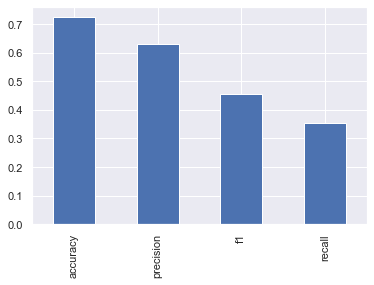

In [53]:
cv_metrics = pd.DataFrame({"accuracy": cv_acc.mean(),
                           "precision": cv_pre.mean(),
                           "f1": cv_f1.mean(),
                           "recall": cv_rec.mean()},
                          index = [0])
cv_metrics.T.plot.bar(legend = False)

In [ ]:
import pickle
filename = "finalized_model.save"
pickle.dump(clf, open(filename, "wb"))

In [ ]:
loaded_model = pickle.load(open(filename,"rb"))
loaded_model.fit(X_train,y_train)
result =loaded_model.score(X_test,y_test)
print(result)

In [55]:
X

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0
